In [1]:
addprocs(7)  # parallel computing

7-element Array{Any,1}:
 2
 3
 4
 5
 6
 7
 8

In [2]:
require("prepare_data_Sioux.jl");
require("extract_data_Sioux.jl");
require("tap_MSA_Sioux.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [3]:
require("initia_data.jl");

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[0]);

In [7]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [8]:
demandsDict[1]

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 289.44453508977125
  (8,23)  => 342.1328320817445
  (6,9)   => 385.1753514638639
  (18,3)  => 0.0
  (21,13) => 574.6055405930682
  (22,16) => 1158.1568225641533
  (15,17) => 1749.063193020558
  (22,14) => 1281.4167354364945
  (13,9)  => 601.1328330978135
  (23,10) => 2019.196063999769
  (24,22) => 1047.480530764622
  (8,9)   => 789.8540755665118
  (9,1)   => 438.40733407625976
  (17,14) => 825.4879488986576
  (16,6)  => 748.9559018591953
  (16,12) => 760.4045859813925
  (16,13) => 635.1896390876957
  (22,2)  => 90.57386461786525
  (24,3)  => 0.0
  (7,16)  => 1223.9591256325177
  (1,12)  => 207.9872917101481
  (4,5)   => 438.35442465018104
  (11,8)  => 689.510803524832
  (18,21) => 115.17327040423227
  (19,4)  => 192.83745763603423
  ⋮        => ⋮

INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...


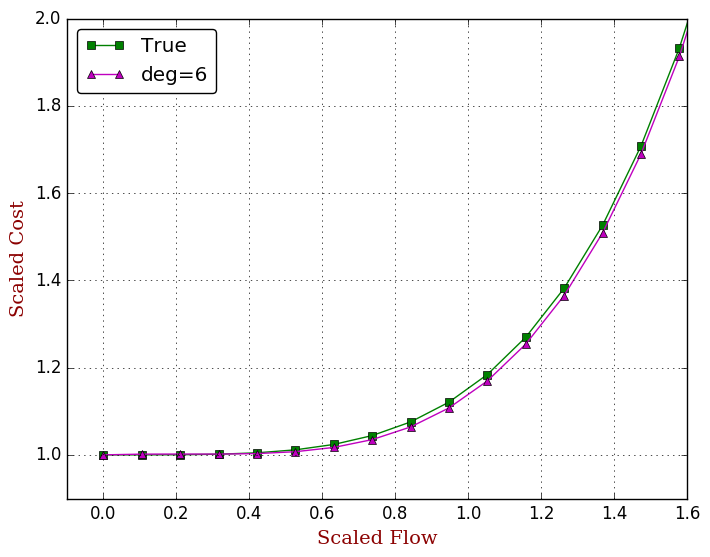

In [9]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

In [10]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [11]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[1]);

In [12]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [13]:
tau = 0.5;

In [14]:
jacobiSpiessDict[1] = jacobianSpiess(numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);

In [15]:
# number of iterations
N = 2;  

In [16]:
jacobiSpiessDict[1]

552x76 Array{Float64,2}:
 0.99849      0.0190035   0.00269606   …  0.16955     0.0         0.0        
 0.00150979   0.00874137  0.0             0.0         0.0700484   0.576601   
 4.62887e-6   0.0         0.0             0.286058    0.0         0.0108161  
 0.0          0.0         0.0             0.16955     0.223254    0.292995   
 4.62887e-6   0.0         0.00351368      0.0         0.0777889   0.168673   
 0.00150516   0.0609847   0.0          …  0.0363216   0.0         0.0        
 4.62887e-6   0.0         0.0             0.00410474  0.59538     0.0        
 0.0          0.0         0.0             0.0         0.00590092  0.239164   
 0.00150798   0.0         0.0             0.0         0.0640173   0.413677   
 9.02252e-7   0.0         0.0             0.00410474  0.0         0.0        
 0.0          0.00210267  0.0          …  0.0         0.0         0.451394   
 0.0015055    0.0516208   0.013467        0.0         0.0956876   0.211688   
 3.09278e-6   0.0         0.0          

In [17]:
for iterNumber = 1:N
    
    l = iterNumber;
    
#     jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
#     free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], 0);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], 10, 3);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[l+1]);
        
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    
    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    odPairRouteDict[l+1] = odPairRouteProb(tau, lengthRouteVec(linkCostDicDict[l+1]), OD_pair_route_dict, numODpairs, 
    numRoutes);
    
    jacobiSpiessDict[l+1] = jacobianSpiess(numLinks, numODpairs, numRoutes, linkRoute, odPairRouteDict[l+1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
        
end

# normalize objective function value
for l = 1:(N+1)
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [18]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 4 entries:
  0 => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,500.0…
  2 => [128.95125124983107,117.9660890510237,558.5968303464509,218.9620360404613…
  3 => [128.95135749137663,117.96614194954908,558.5969326331949,218.962237552092…
  1 => [118.91664383806138,118.37618359254327,547.6620230848335,209.061574743780…

In [19]:
norObjFunDict

Dict{Int64,Float64} with 3 entries:
  2 => 0.9420531670434823
  3 => 0.9420521075526679
  1 => 1.0

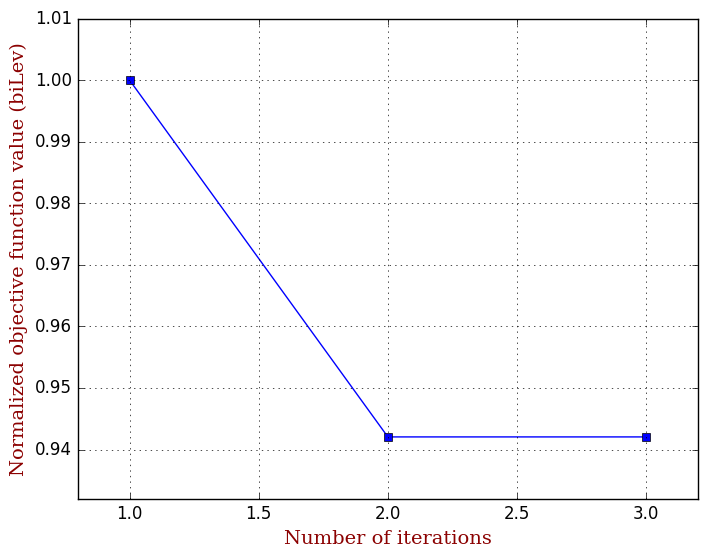

In [20]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Sioux.pdf")

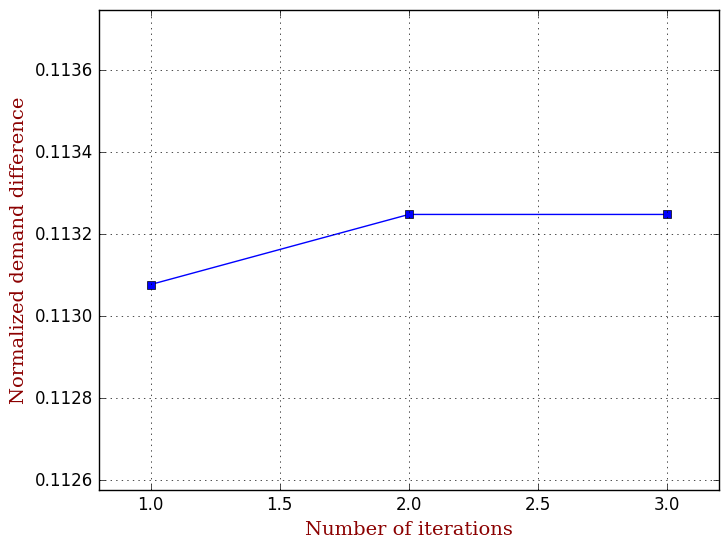

In [21]:
using PyPlot

iterNum = 1:(N+1)

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Sioux.pdf")

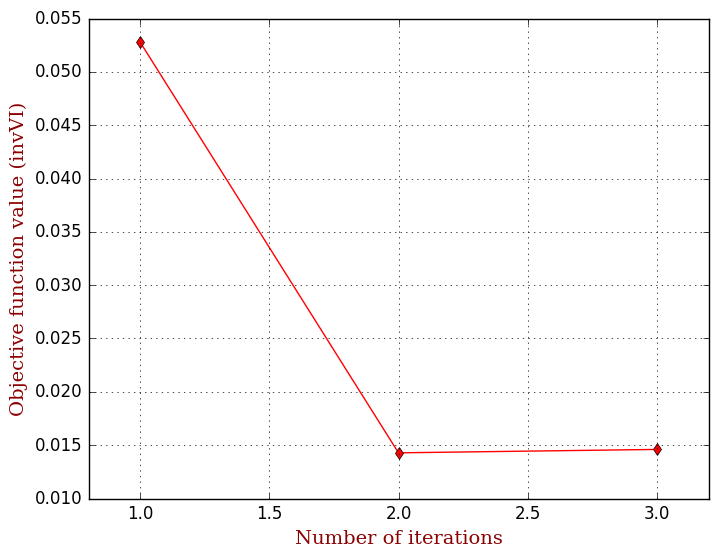

In [22]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "d-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Sioux.pdf")

In [23]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 3 entries:
  (6,3.41,1.0,2) => [1.0,0.0355558644079131,-0.14091377800178212,0.1431524936908…
  (6,3.41,1.0,3) => [1.0,0.03299617842277576,-0.13729758529485273,0.147281676462…
  (6,3.41,1.0,1) => [1.0,0.025783719819053245,-0.10444243176045791,0.08765937226…

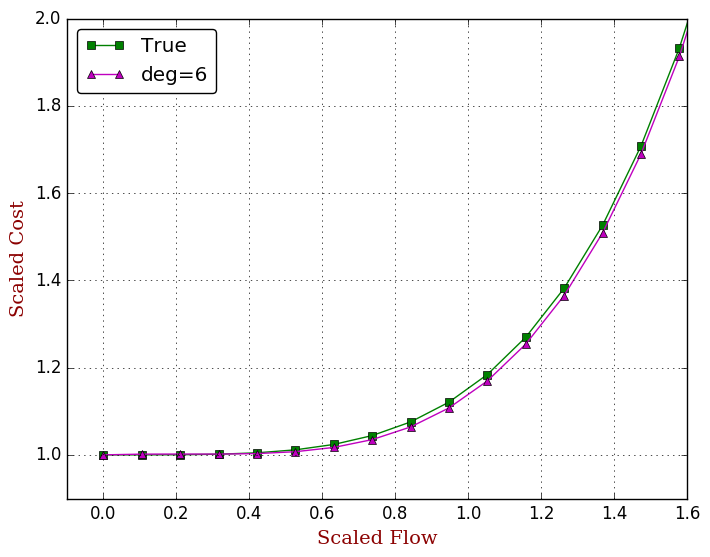

In [24]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

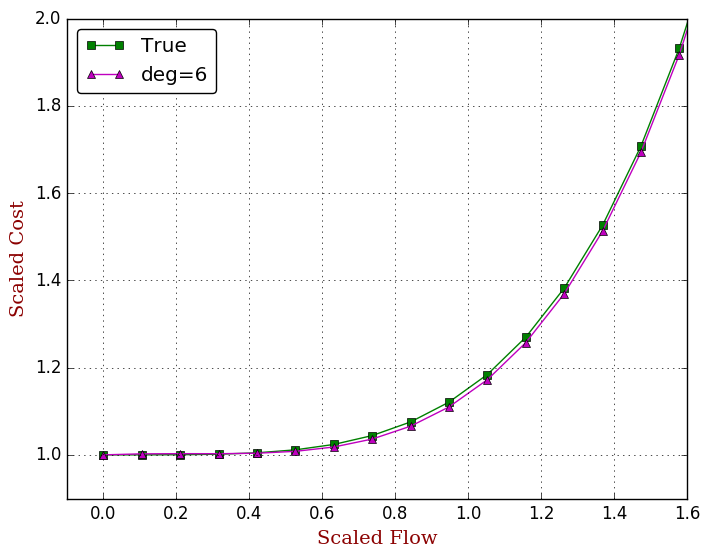

In [25]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

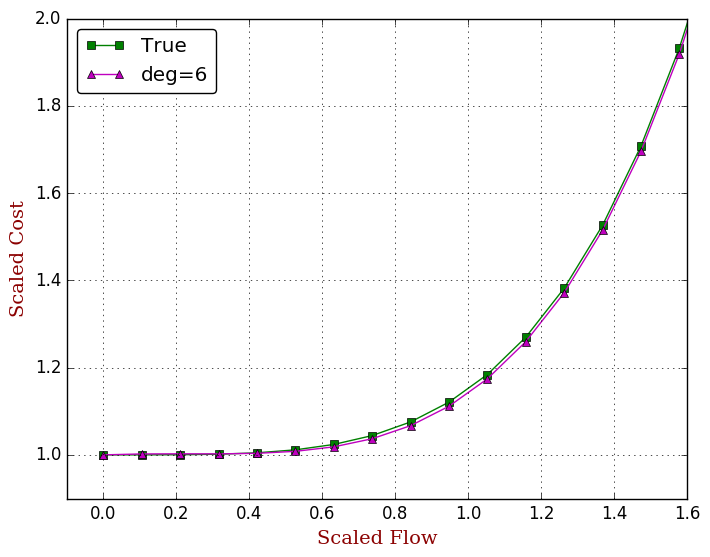

In [26]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")